<a href="https://colab.research.google.com/github/tjdrhks0808/Project-Road_Accident/blob/main/Daejeon_Conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------
# 교통사고 위험지역 100개소 선정
----------

In [ ]:
from geoband.API import *

from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
import geopy.distance

import pydeck as pdk
import shapely
import shapefile
import os
import re
import mapboxgl
from mapboxgl.viz import *
import seaborn as sns

import platform
import requests; from urllib.parse import urlparse

import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력

from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
## 데이터 로드

daejeon = gpd.read_file('daejeon_data.geojson')
daejeon = daejeon[daejeon.isroad==1]

daejeon = daejeon.reset_index(drop=True, inplace=False)

In [ ]:
## 예측값 삽입

pred_ctc = pd.read_csv('pred_ctc.csv')
pred_cth = pd.read_csv('pred_cth.csv')

daejeon['pred_risk_ctc'] = pred_ctc.iloc[:, 1]
daejeon['pred_risk_cth'] = pred_cth.iloc[:, 1]
daejeon['pred_risk'] = daejeon.pred_risk_ctc + daejeon.pred_risk_cth
daejeon['pr_score_ctc'] = daejeon.acci_risk_ctc - daejeon.pred_risk_ctc
daejeon['pr_score_cth'] = daejeon.acci_risk_ctc - daejeon.pred_risk_cth
daejeon['pr_score'] = daejeon.acci_risk - daejeon.pred_risk

In [ ]:
## 상위 격자 추출

top = daejeon.sort_values(by=['pr_score'], axis=0, ascending=False).iloc[range(115), :]

In [ ]:
## 위치 기반 클러스터링 진행

top_x = top.copy()

top_x['lat'] = [ np.array(x.centroid.xy)[0][0] for x in top.geometry]
top_x['lon'] = [ np.array(x.centroid.xy)[1][0] for x in top.geometry]
top_x = top_x.loc[:, ['lat', 'lon']]
top_x_scaled = minmax_scale(top_x, axis=0, copy=True)

estimator = KMeans(n_clusters=100, random_state=123)
cluster_idx = estimator.fit_predict(top_x_scaled)
top['cluster'] = cluster_idx

In [ ]:
# 여러 격자가 하나의 클러스터로 묶인 경우

top.cluster.value_counts()[top.cluster.value_counts()>1]

70    3
90    2
14    2
59    2
83    2
61    2
56    2
55    2
53    2
29    2
24    2
96    2
42    2
15    2
Name: cluster, dtype: int64

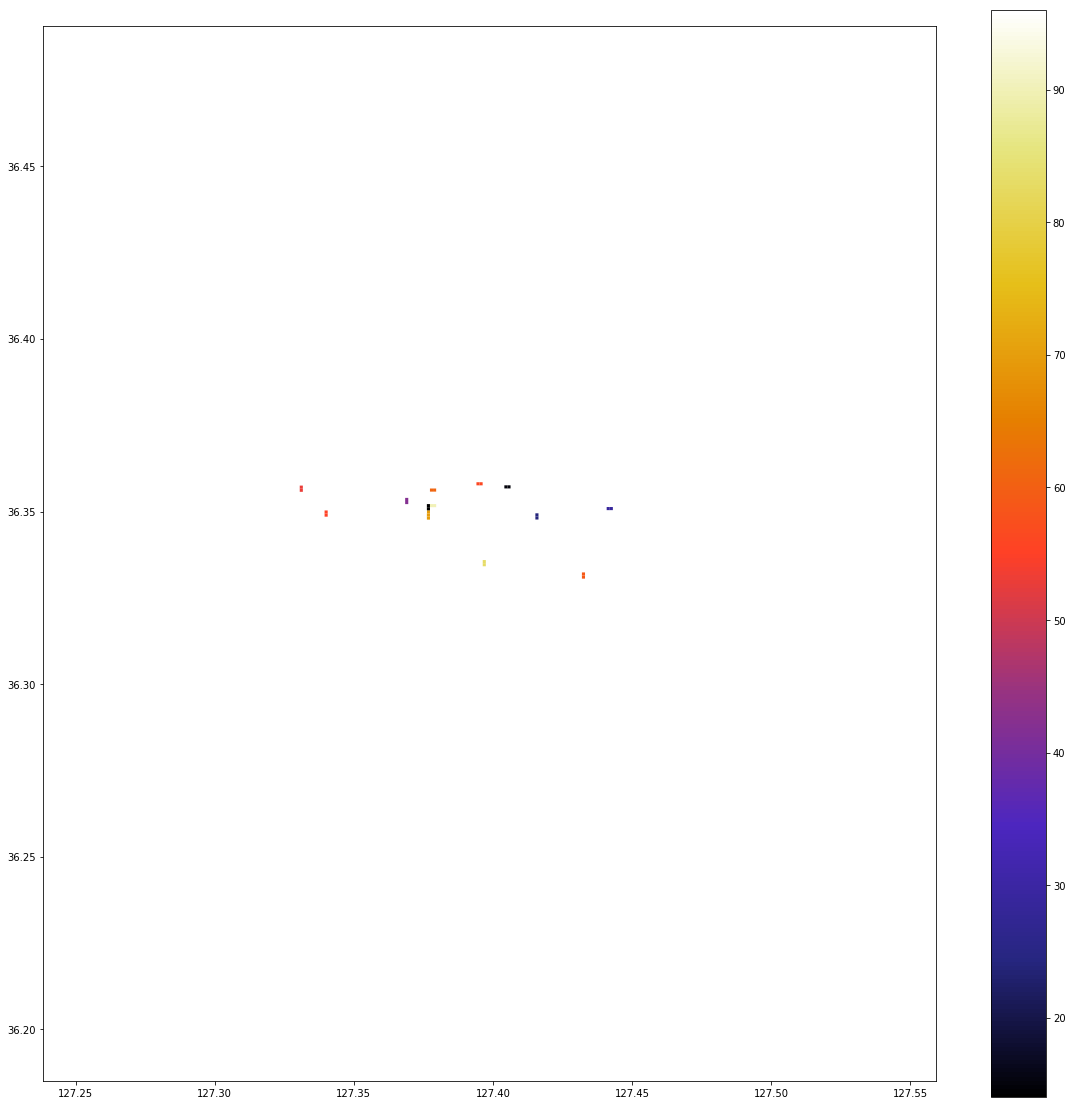

In [ ]:
# 위치 기반 클러스터링으로 묶인 격자 시각화

plt.rcParams["figure.figsize"] = (20,20)
plot1 = daejeon.plot(color='white')
plot2 = top[ (top.cluster==70)|
           (top.cluster==90)|
           (top.cluster==14)|
           (top.cluster==59)|
           (top.cluster==83)|
           (top.cluster==61)|
           (top.cluster==56)|
           (top.cluster==55)|
           (top.cluster==53)|
           (top.cluster==29)|
           (top.cluster==24)|
           (top.cluster==96)|
           (top.cluster==42)|
           (top.cluster==15)].plot(ax=plot1, column='cluster', cmap='CMRmap', legend=True)

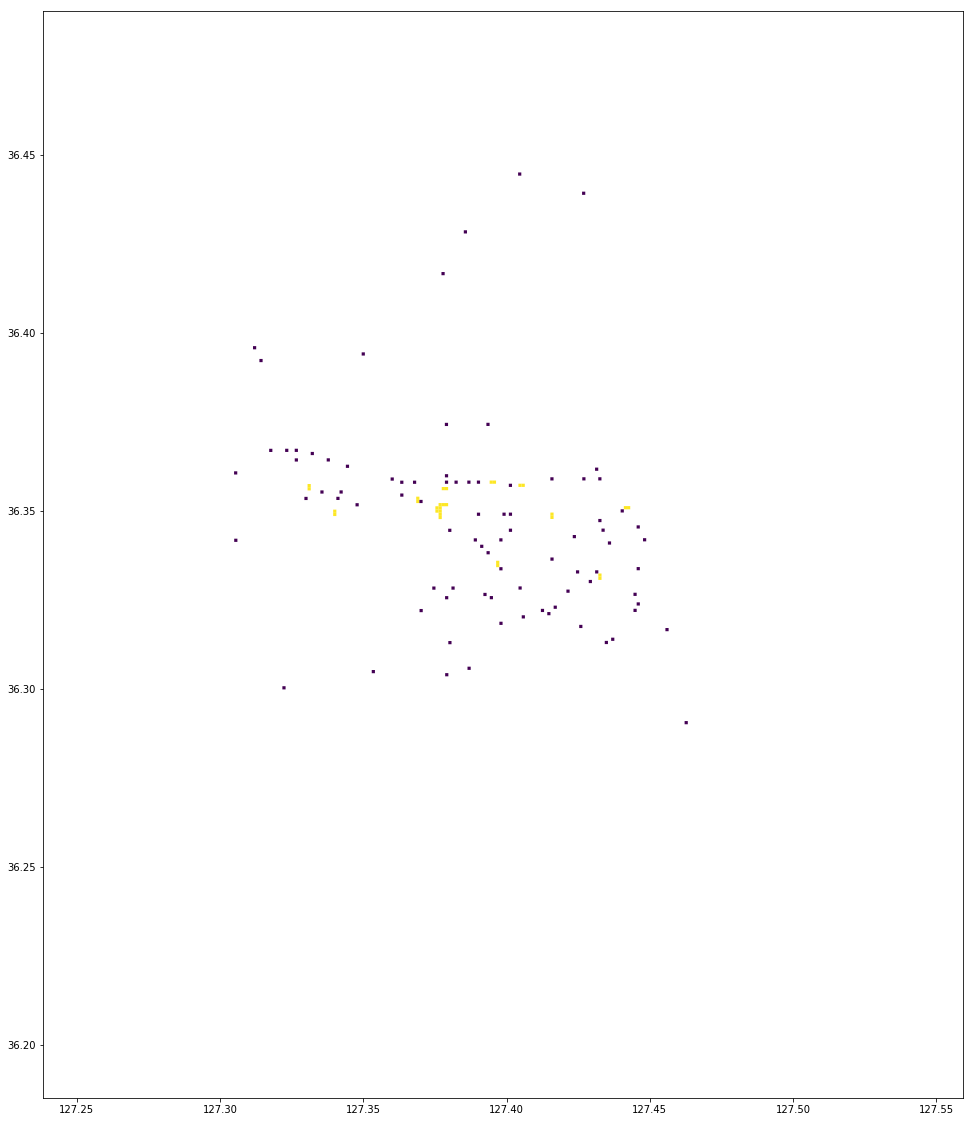

In [ ]:
# 하나로 묶은 격자를 포함하여 추천되는 100 격자(노랑 : 다수의 격자 묶음, 보라 : 하나의 격자)

top['unit'] = [1 if x in [70, 90, 14, 59, 83, 61, 56, 55, 53, 29, 24, 96, 42, 15] else 0 for x in top.cluster]

plt.rcParams["figure.figsize"] = (20,20)
plot1 = daejeon.plot(color='white')
plot2 = top.plot(ax=plot1, column='unit')

In [ ]:
# 사고위험 있는 격자를 반경을 포함하여 데이터프레임으로 저장

from shapely.geometry import Point, Polygon, LineString

cluster_list = []
center_list = []
radius_list = []
geometry_list = []
pr_score_list = []
pr_score_ctc_list = []
pr_score_cth_list = []

for idx in range(100):
    
    if len(top[top.cluster==idx]) > 2 :
        
        geom_list = [x.centroid for x in top[top.cluster==idx].geometry]
        geom_tuple = tuple(geom_list)
        geo_srs = gpd.GeoSeries(geom_list)
        
        center = Polygon(geom_tuple).centroid
        
        radius = max(geo_srs.distance(center))
        
        cluster_list.append(idx)
        center_list.append(center)
        radius_list.append(radius)
        geometry_list.append(center.buffer(radius))
        
        pr_score_list.append((np.mean(top[top.cluster==idx].pr_score)))
        pr_score_ctc_list.append((np.mean(top[top.cluster==idx].pr_score_ctc)))
        pr_score_cth_list.append((np.mean(top[top.cluster==idx].pr_score_cth)))
        
    elif len(top[top.cluster==idx]) == 2 :
        
        geom_list = [x.centroid for x in top[top.cluster==idx].geometry]
        geom_tuple = tuple(geom_list)
        geo_srs = gpd.GeoSeries(geom_list)
        
        center = Point( (geom_list[0].xy[0][0]+geom_list[1].xy[0][0])/2, (geom_list[0].xy[1][0]+geom_list[1].xy[1][0])/2 )
        
        radius = max(geo_srs.distance(center))
        
        cluster_list.append(idx)
        center_list.append(center)
        radius_list.append(radius)
        geometry_list.append(center.buffer(radius))
        
        pr_score_list.append((np.mean(top[top.cluster==idx].pr_score)))
        pr_score_ctc_list.append((np.mean(top[top.cluster==idx].pr_score_ctc)))
        pr_score_cth_list.append((np.mean(top[top.cluster==idx].pr_score_cth)))
        
    else:
        cluster_list.append(idx)
        center_list.append(list(top[top.cluster==idx].geometry.centroid)[0])
        radius_list.append(0.0005)
        geometry_list.append(list(top[top.cluster==idx].geometry.centroid)[0].buffer(0.0005))
        
        pr_score_list.append((np.mean(top[top.cluster==idx].pr_score)))
        pr_score_ctc_list.append((np.mean(top[top.cluster==idx].pr_score_ctc)))
        pr_score_cth_list.append((np.mean(top[top.cluster==idx].pr_score_cth)))
        
        
top_100 = pd.DataFrame({'cluster':cluster_list, 'center':center_list, 'radius':radius_list, 'geometry':geometry_list,
                        'pr_score':pr_score_list, 'pr_score_ctc':pr_score_ctc_list, 'pr_score_cth':pr_score_cth_list})
top_100 = gpd.GeoDataFrame(top_100)    

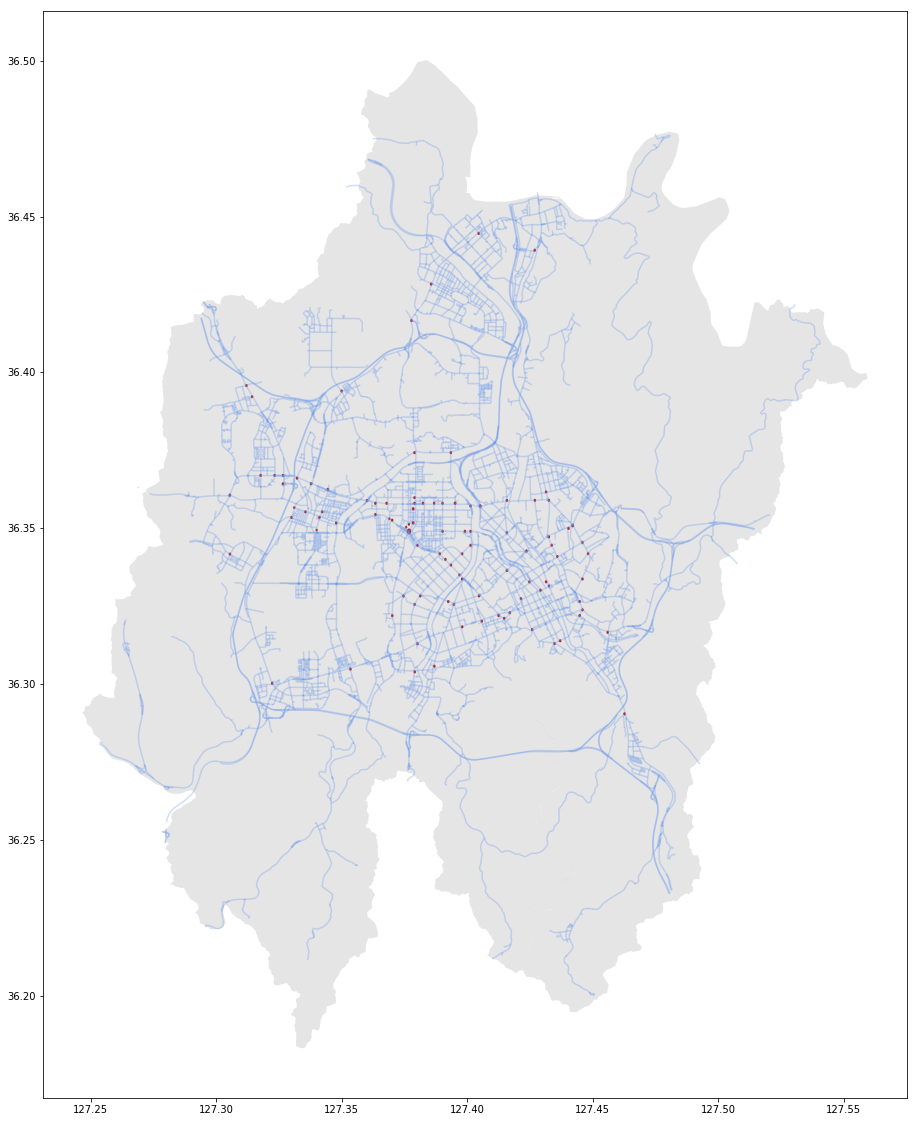

In [ ]:
# 최종 교통사고 위험지역 100개소 시각화

bound_law2 = gpd.read_file('26.대전광역시_법정경계(읍면동).geojson')
traffic_road = gpd.read_file('19.대전광역시_상세도로망(2018).geojson')

plt.rcParams["figure.figsize"] = (20,20)
plot1 = bound_law2.plot(color='darkgrey', alpha=0.3)
plot2 = top_100.plot(ax=plot1, color='firebrick', legend=True)
plot3 = traffic_road.plot(ax=plot2, color='cornflowerblue', alpha=0.3)

In [ ]:
## 최종 결과물 저장

In [ ]:
top_100['lon'] = [x.xy[0][0] for x in top_100.center]
top_100['lat'] = [x.xy[1][0] for x in top_100.center]
top_100['radius'] = [50 if x < 0.0006 else 100 for x in top_100.radius]

In [ ]:
result = top_100.sort_values(by=['pr_score'], axis=0, ascending=False)
result['rank'] = range(1, 101)
result = result.loc[:, ['rank', 'lon', 'lat', 'radius']]
result = pd.DataFrame(result)

In [ ]:
result.to_csv('result.csv')